# Introduction

This notebook demonstrates how you can obtain various data from the Materials Project using pymatgen's interface to the Materials API.

In [2]:
from pymatgen import MPRester, Composition
import re
import pprint

# Make sure that you have the Materials API key. Put the key in the call to
# MPRester if needed, e.g, MPRester("MY_API_KEY")
mpr = MPRester()

# Getting structures with material ids

Let's say you want to find all structures with similar stoichiometry to Fe2O3.

In [3]:
comp = Composition("Fe2O3")
anon_formula = comp.anonymized_formula
# We need to convert the formula to the dict form used in the database.
anon_formula = {m.group(1): int(m.group(2)) 
                for m in re.finditer(r"([A-Z]+)(\d+)", anon_formula)}

data = mpr.query({"anonymous_formula": anon_formula}, 
                 properties=["task_id", "pretty_formula", "structure"])
print(len(data))  #Should show ~600 data.

601


In [4]:
# data now contains a list of dict. This shows you what each dict has.
# Note that the mp id is named "task_id" in the database itself.
pprint.pprint(data[0])  

{'pretty_formula': 'Gd2O3',
 'structure': Structure Summary
Lattice
    abc : 3.7465563099999999 3.7465563064877148 5.95228761
 angles : 90.0 90.0 119.99999994271758
 volume : 72.35675272229777
      A : 3.7465563099999999 0.0 0.0
      B : -1.87327815 3.2446129400000001 0.0
      C : 0.0 0.0 5.95228761
PeriodicSite: O (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: O (1.8733, 1.0815, 2.1102) [0.6667, 0.3333, 0.3545]
PeriodicSite: O (-0.0000, 2.1631, 3.8421) [0.3333, 0.6667, 0.6455]
PeriodicSite: Gd (1.8733, 1.0815, 4.4720) [0.6667, 0.3333, 0.7513]
PeriodicSite: Gd (-0.0000, 2.1631, 1.4803) [0.3333, 0.6667, 0.2487],
 'task_id': 'mp-20470'}


# Getting band structures

Band structures are fairly large objects. It is not recommended that you download large quantities of bandstructures in one shot, but rather just download the ones you need.

In [5]:
bs = mpr.get_bandstructure_by_material_id("mp-20470")

In [6]:
from pymatgen.electronic_structure.plotter import BSPlotter
%matplotlib inline

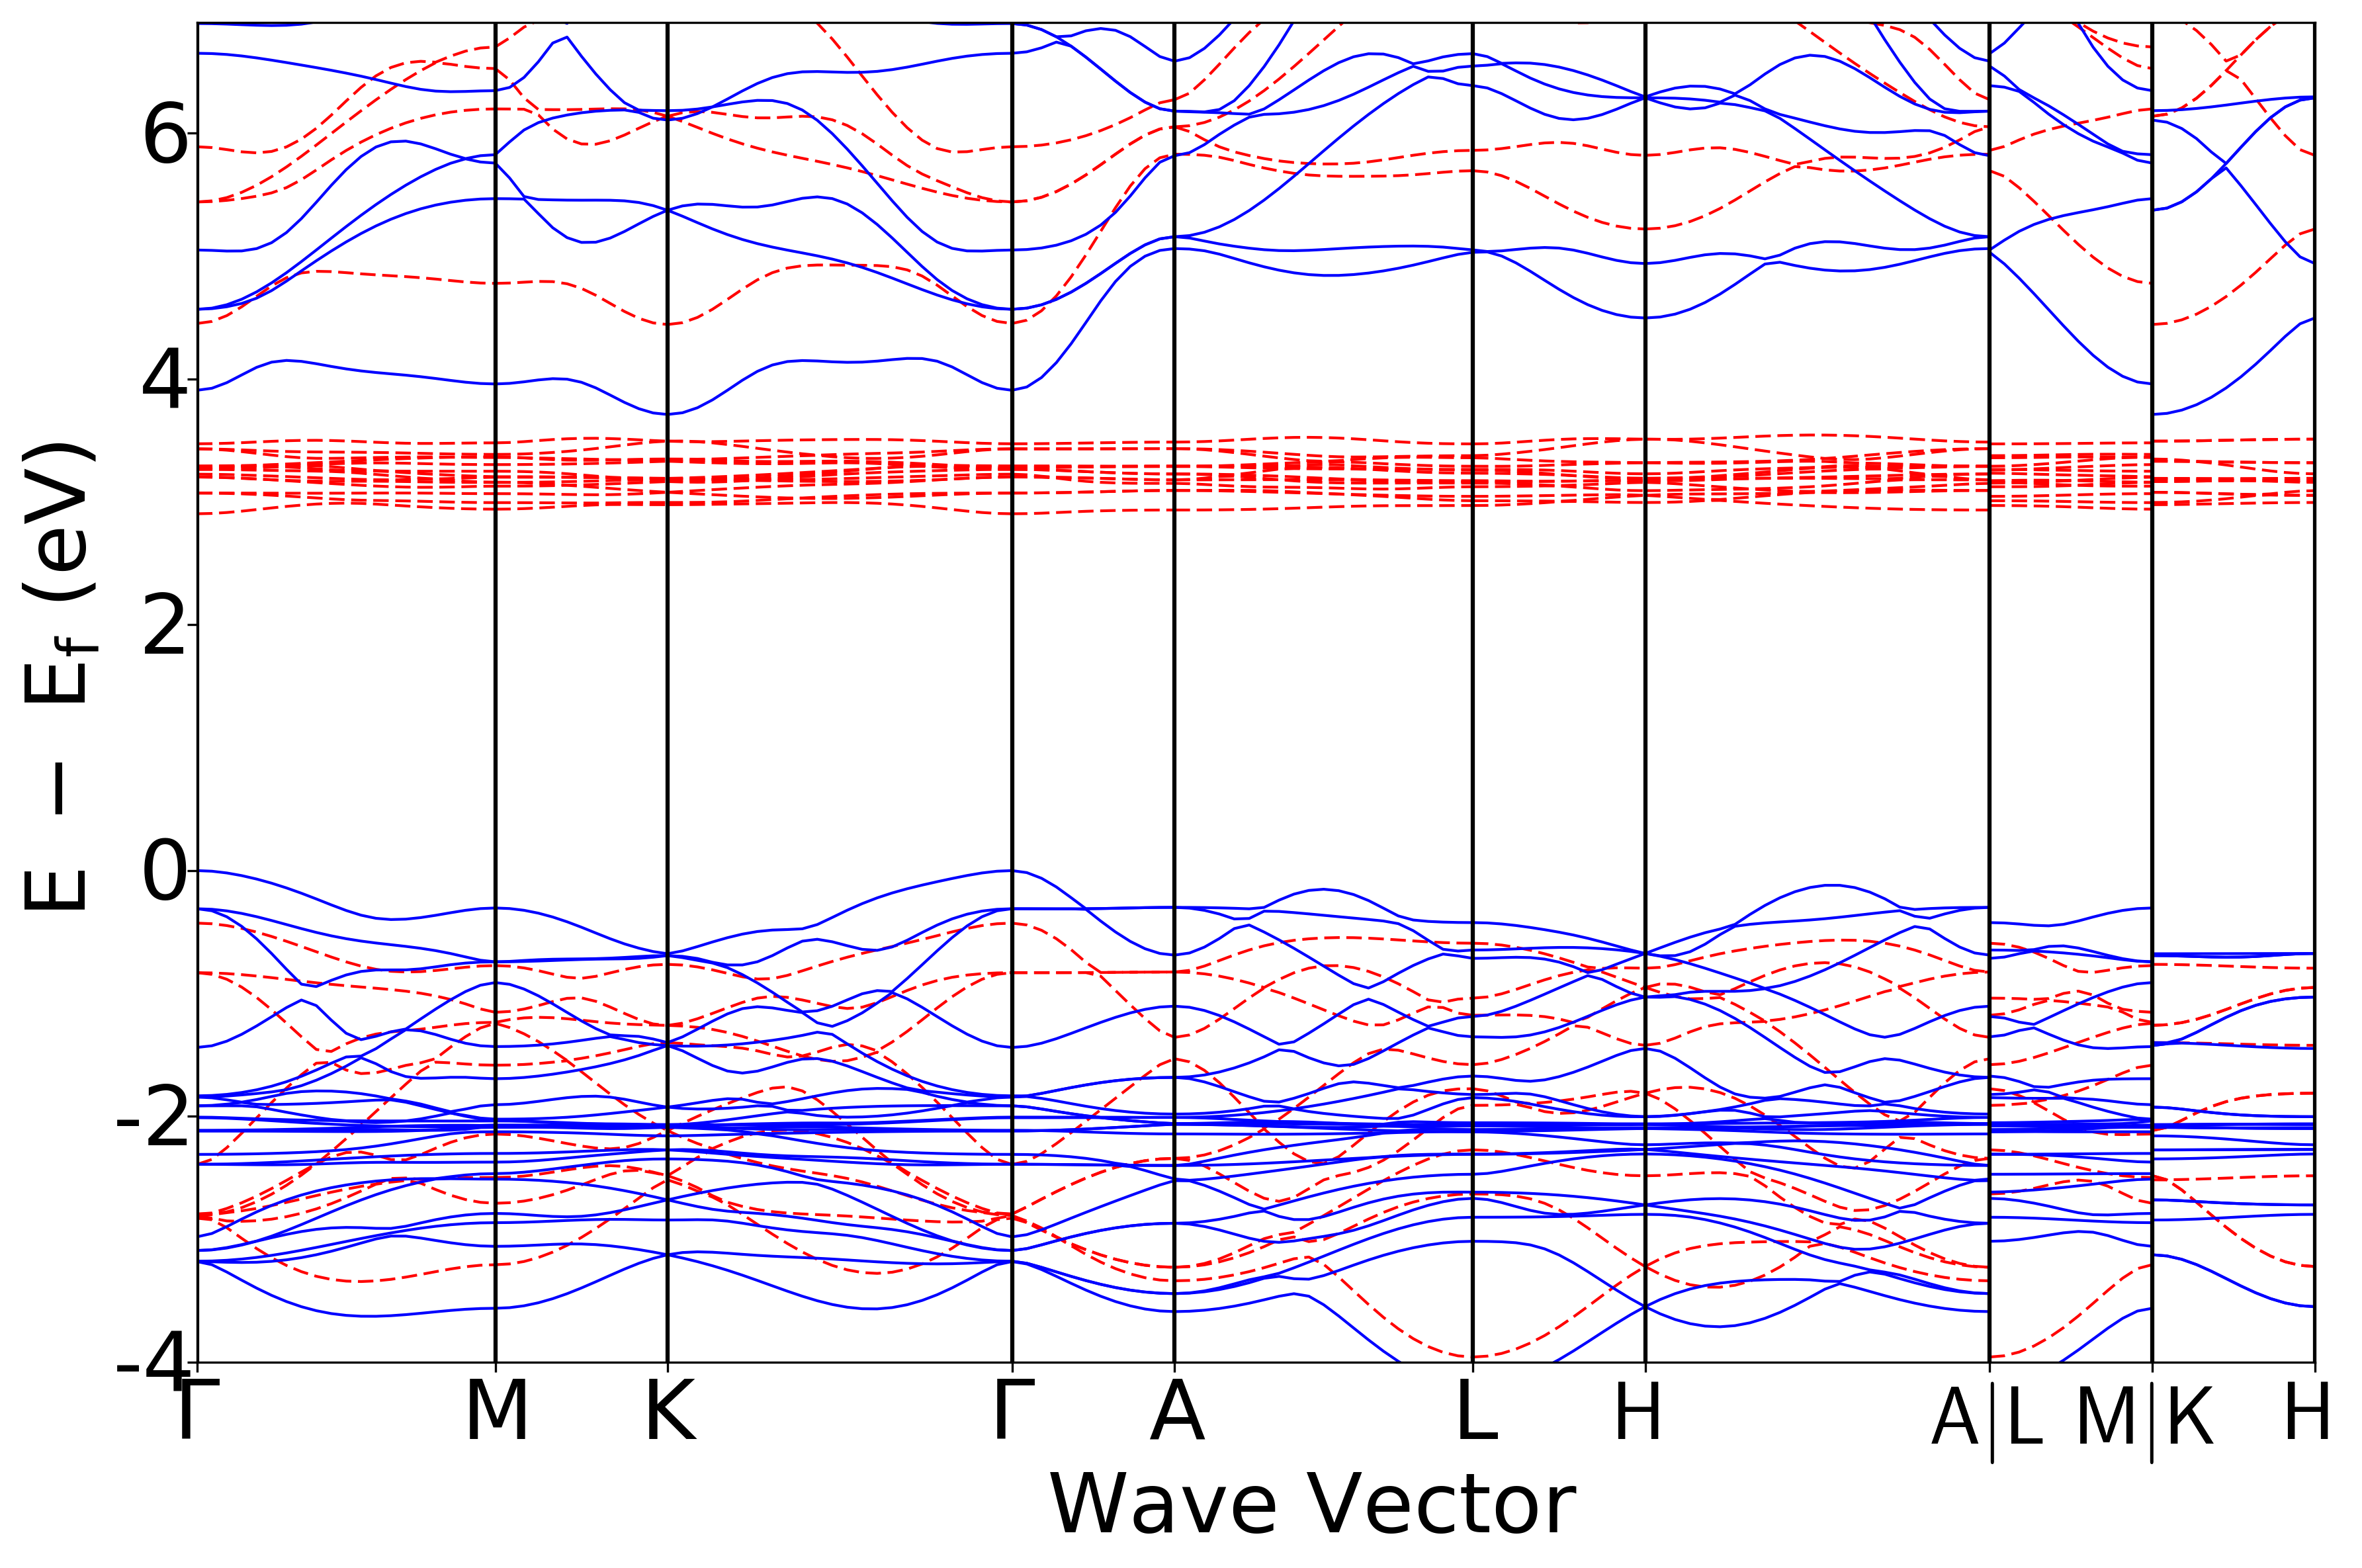

In [7]:
plotter = BSPlotter(bs)
plotter.show()

# Getting elastic constants

We have 5000 elastic constants and growing. You can easily get all the elastic data with materials ids as follows.

In [8]:
elastic_data = mpr.query({"elasticity": {"$exists": True}}, 
                         properties=["task_id", "pretty_formula", "elasticity"])

In [9]:
print(len(elastic_data))
pprint.pprint(elastic_data[0])

4430
{'elasticity': {'G_Reuss': 76.91447318267569,
                'G_VRH': 78.18817104828827,
                'G_Voigt': 79.46186891390086,
                'G_Voigt_Reuss_Hill': 78.18817104828827,
                'K_Reuss': 144.2366332633269,
                'K_VRH': 145.7020495842338,
                'K_Voigt': 147.16746590514072,
                'K_Voigt_Reuss_Hill': 145.7020495842338,
                '_id': '5735a3f134c4c5e485d35019',
                'compliance_tensor': [[6.543883959985022,
                                       -2.0589506583054304,
                                       -1.560930973876778,
                                       0.0,
                                       0.0,
                                       0.0],
                                      [-2.0589506583054304,
                                       4.976676822003074,
                                       -0.5446050307190493,
                                       0.0,
                         

# More resources

In general, almost any data can be obtained from MP using the MPRester, either via the high-level functions or the very powerful "query" method.

For more complex queries, you can refer to the documentation for the Materials API at https://github.com/materialsproject/mapidoc. 

# Fitting structures

Pymatgen has its own structure matching algorithm, which we have used to effectively reduce the 130,000 structures in ICSD to ~60,000 - 70,000 structures. It is fast and accurate. Here's an example of how it works.

In [10]:
from pymatgen.analysis.structure_matcher import StructureMatcher

In [11]:
m = StructureMatcher() # You can customize tolerances etc., but the defaults usually work fine.

In [14]:
s1 = data[0]["structure"]
print(s1)
s2 = s1.copy()
s2.apply_strain(0.1)
print(s2)

Full Formula (Gd2 O3)
Reduced Formula: Gd2O3
abc   :   3.746556   3.746556   5.952288
angles:  90.000000  90.000000 120.000000
Sites (5)
  #  SP           a         b         c    coordination_no  forces
---  ----  --------  --------  --------  -----------------  -----------------------
  0  O     0         0         0                         8  [0.0, 0.0, 0.0]
  1  O     0.666667  0.333333  0.354517                  6  [0.0, 0.0, 0.01029438]
  2  O     0.333333  0.666667  0.645483                  6  [0.0, 0.0, -0.01029438]
  3  Gd    0.666667  0.333333  0.751313                  6  [0.0, 0.0, 0.01786635]
  4  Gd    0.333333  0.666667  0.248687                  6  [0.0, 0.0, -0.01786635]
Full Formula (Gd2 O3)
Reduced Formula: Gd2O3
abc   :   4.121212   4.121212   6.547516
angles:  90.000000  90.000000 120.000000
Sites (5)
  #  SP           a         b         c    coordination_no  forces
---  ----  --------  --------  --------  -----------------  -----------------------
  0  O     0  

In [15]:
print(m.fit(s1, s2)) 

True


For something more challenging, let's see how many structures are similar to Gd2O3

In [16]:
matches = []
for d in data:
    if m.fit_anonymous(d["structure"], s1):
        matches.append(d)

In [17]:
# The above fitting took a few seconds. We have 32 similar structures.
print(len(matches))

32


In [18]:
# Let's see a few of the matches.
pprint.pprint(matches[0])
pprint.pprint(matches[1])
pprint.pprint(matches[2])

{'pretty_formula': 'Gd2O3',
 'structure': Structure Summary
Lattice
    abc : 3.7465563099999999 3.7465563064877148 5.95228761
 angles : 90.0 90.0 119.99999994271758
 volume : 72.35675272229777
      A : 3.7465563099999999 0.0 0.0
      B : -1.87327815 3.2446129400000001 0.0
      C : 0.0 0.0 5.95228761
PeriodicSite: O (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: O (1.8733, 1.0815, 2.1102) [0.6667, 0.3333, 0.3545]
PeriodicSite: O (-0.0000, 2.1631, 3.8421) [0.3333, 0.6667, 0.6455]
PeriodicSite: Gd (1.8733, 1.0815, 4.4720) [0.6667, 0.3333, 0.7513]
PeriodicSite: Gd (-0.0000, 2.1631, 1.4803) [0.3333, 0.6667, 0.2487],
 'task_id': 'mp-20470'}
{'pretty_formula': 'La2O3',
 'structure': Structure Summary
Lattice
    abc : 3.9383411000000002 3.9383410988149739 6.18029312
 angles : 90.0 90.0 120.00000000995352
 volume : 83.016871001127868
      A : 3.9383411000000002 0.0 0.0
      B : -1.9691705500000001 3.4107034399999998 0.0
      C : 0.0 0.0 6.18029312
PeriodicSite: O (1.969

You can see that we have successfully found iso-structural materials!